# How to us our wav2vec 2.0 model for speech emotion recognition

In the following we present a hands-on to our model for dimensional emotional emotion recognition based on wav2vec 2.0. The model is publicly available for non-commercial usage from https://doi.org/10.5281/zenodo.6221127.

## Load model

We start by downloading and unpacking the model. This will get us two files, a binary ONNX file containing the model weights and a YAML file with meta information about the model.

In [1]:
import os

import audeer


model_root = 'model'
cache_root = 'cache'


audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)


url = 'https://zenodo.org/record/6221127/files/w2v2-L-robust-12.6bc4a7fd-1.1.0.zip'
dst_path = cache_path('model.zip')

if not os.path.exists(dst_path):
    audeer.download_url(
        url, 
        dst_path, 
        verbose=True,
    )
    audeer.extract_archive(
        dst_path, 
        model_root, 
        verbose=True,
    )

The package [audonnx](https://github.com/audeering/audonnx) helps us to load the model. Printing the model lists the input and output nodes. Since the model operates on the raw audio stream, we have a single input node called 'signal', which expects a mono signal with a sampling rate of 16000Hz. We also see that the model has two output nodes: 'hidden_states', which gives us access to the pooled states of the last transformer layer and 'logits', which provides scores for arousal, dominance and valence in a range of approximately 0...1.

In [2]:
import audonnx


model = audonnx.load(model_root)
model

Input:
  signal:
    shape: [1, -1]
    dtype: tensor(float)
    transform: None
Output:
  hidden_states:
    shape: [1, 1024]
    dtype: tensor(float)
    labels: [hidden_states-0, hidden_states-1, hidden_states-2, (...), hidden_states-1021,
      hidden_states-1022, hidden_states-1023]
  logits:
    shape: [1, 3]
    dtype: tensor(float)
    labels: [arousal, dominance, valence]

As a test, we call the model with some white noise. Note that we have to force the data type of the signal to 32-bit floating point precision. As result we get a dictionary with predictions for every output node.

In [3]:
import numpy as np


sampling_rate = 16000
signal = np.random.normal(
    size=sampling_rate,
).astype(np.float32)

model(signal, sampling_rate)

{'hidden_states': array([[-0.00715177,  0.00623909, -0.00782055, ...,  0.00666184,
          0.00948612,  0.00272968]], dtype=float32),
 'logits': array([[0.677089 , 0.6423461, 0.5043235]], dtype=float32)}

## Predict arousal, dominance and valence

A more advanced way of interfacing the model is offered by [audinterface](https://github.com/audeering/audinterface). Especially, the class [Feature](https://audeering.github.io/audinterface/api.html#feature) comes in handy, as it has the option to assign names to the output dimensions. To create the interface, we simply pass our callable model object as processing function. Since we are only interested in the scores for arousal, dominance and valence, we pass 'logits' as an additional key word argument to `output_names`. And we enable automatic resampling in case the expected sampling rate of the model is not matched.

In [4]:
import audinterface


interface = audinterface.Feature(
    model.outputs['logits'].labels,
    process_func=model,
    process_func_args={
        'output_names': 'logits',
    },
    sampling_rate=sampling_rate,
    resample=True,    
    verbose=True,
)

When we pass the signal to the interface, we get as result a table with proper column labels.

In [5]:
interface.process_signal(signal, sampling_rate)

,,arousal,dominance,valence
start,end,,,
0 days,0 days 00:00:01,0.677089,0.642346,0.504323


## Predict dimensional scores on synthetic files 

In the [paper](add link), we made the observation that transformer-based models - even though not trained on textual transcriptions - can implicitly learn linguistic information. To prove this for the model at hand, we repeat an experiment, where we predict neutral sounding files generated with a text-to-speech engine. First, we let [gTTS](https://pypi.org/project/gTTS/) (Google Text-to-Speech) create some sentences for us. In two of the sentences we include words with a strong positive and negative sentiment ('wonderful' / 'stupid').

In [6]:
import gtts
import IPython


sentences = [
    'This is a notebook',
    'This is wonderful',
    'This is stupid',
]

tts_files = []
for sentence in audeer.progress_bar(
    sentences,
    desc='Create files',
):
    tts_path = cache_path(f'{sentence}.mp3')
    tts_files.append(tts_path)
    if not os.path.exists(tts_path):
        tts = gtts.gTTS(sentence)
        tts.save(path)

for tts_file in tts_files:
    IPython.display.display(IPython.display.Audio(tts_file))

With help of the interface we can run the model directly on the list with file names. The interesting bit here is the valence score, which - despite a neutral sounding voice - is high for the sentence including the word 'wonderful' and zero for the sentence including the word 'stupid'. This proves the sensibility of the model to sentiment.

In [7]:
interface.process_files(tts_files).round(2)

,,,arousal,dominance,valence
file,start,end,,,
cache/This is a notebook.mp3,0 days,0 days 00:00:01.584000,0.50,0.54,0.53
cache/This is wonderful.mp3,0 days,0 days 00:00:01.632000,0.55,0.65,0.90
cache/This is stupid.mp3,0 days,0 days 00:00:01.560000,0.55,0.66,-0.00


## Use embeddings to train categorical emotion model

The Berlin Database of Emotional Speech ([Emo-DB](emodb.bilderbar.info)) is a well known speech databases with emotional utterances by different actors. Since it is in German and contains nonsense sentences, it will allow us to investigate if a) the model works on languages other than English b) it can also predict valence from paralinguistics only. To get the database we use [audb](https://github.com/audeering/audb), a package to manage annotated media files. When we load the data, audb takes care of caching and converting the files to the desired format. Annotations are organized as tables in [audformat](https://github.com/audeering/audformat). In the following experiment we use columns with speaker information and emotional labels.

In [8]:
import audb
import audformat


db = audb.load(
    'emodb',
    version='1.1.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    full_path=False,    
    cache_root=cache_root,
    verbose=True,
)
speaker = db['files']['speaker'].get()
emotion = db['emotion']['emotion'].get()

audformat.utils.concat([emotion, speaker])

Get:   emodb v1.1.1
Cache: /media/jwagner/Data/Git/how-to/w2v2-how-to/cache/emodb/1.1.1/fe182b91


,emotion,speaker
file,,
wav/03a01Fa.wav,happiness,3
wav/03a01Nc.wav,neutral,3
wav/03a01Wa.wav,anger,3
wav/03a02Fc.wav,happiness,3
wav/03a02Nc.wav,neutral,3
...,...,...
wav/16b10Lb.wav,boredom,16
wav/16b10Tb.wav,sadness,16
wav/16b10Td.wav,sadness,16


Since the model was fine-tuned on dimensional scores and not categerical labels, a fine-tuning to the new targets is required. Therefore we use the output of 'hidden_states' to access to the latent space of the model, also called embeddings. We assume that they provide a compact representation of the emotional content embedded in a speech signal. The interface we created earlier offers us a convenient way to run the model directly on the index of a table. Note that we cache the feature once extracted to avoid re-calculation.

In [9]:
import pandas as pd


hidden_states = audinterface.Feature(
    model.outputs['hidden_states'].labels,
    process_func=model,
    process_func_args={
        'output_names': 'hidden_states',
    },
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('w2v2.pkl')
if not os.path.exists(path):
    features_w2v2 = hidden_states.process_index(
        emotion.index,
        root=db.root,
    )
    features_w2v2.to_pickle(path)    
    
features_w2v2 = pd.read_pickle(path)
features_w2v2

,,,hidden_states-0,hidden_states-1,hidden_states-2,hidden_states-3,hidden_states-4,hidden_states-5,hidden_states-6,hidden_states-7,hidden_states-8,hidden_states-9,...,hidden_states-1014,hidden_states-1015,hidden_states-1016,hidden_states-1017,hidden_states-1018,hidden_states-1019,hidden_states-1020,hidden_states-1021,hidden_states-1022,hidden_states-1023
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,-0.007891,0.006736,-0.005898,-0.006566,-0.004559,-0.008148,0.168698,0.006812,0.113164,-0.001617,...,0.003587,0.011148,-0.050405,0.008359,0.034025,-0.064220,0.139168,0.007794,0.007637,0.006209
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,-0.007629,0.006001,-0.007628,-0.006588,-0.005104,-0.008472,0.199000,0.006391,0.071222,-0.001760,...,0.003145,0.011300,-0.018726,0.008156,0.015245,-0.056928,0.083291,0.007600,0.007721,0.005684
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,-0.007874,0.006600,-0.008576,-0.007047,-0.004646,-0.008129,0.237001,0.007115,0.188141,-0.001287,...,0.003982,0.011190,-0.036640,0.008163,0.062221,-0.112500,0.302140,0.007813,0.007812,0.007133
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,-0.007407,0.006326,-0.010519,-0.005899,-0.004216,-0.007912,0.109786,0.006558,0.088926,-0.001507,...,0.003656,0.011320,-0.041450,0.008284,-0.010972,-0.139131,0.366497,0.007560,0.008487,0.004726
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,-0.007313,0.006525,-0.010693,-0.004869,-0.004605,-0.008149,0.122609,0.006291,0.032912,-0.001508,...,0.003650,0.010983,-0.058476,0.008078,-0.008553,-0.000632,0.296581,0.007574,0.008161,0.005591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,-0.007212,0.006251,-0.006754,-0.006353,-0.004147,-0.007847,0.023312,0.007121,0.040396,-0.001996,...,0.003988,0.011588,-0.043439,0.008200,-0.027195,-0.063882,-0.051351,0.007314,0.007467,0.005633
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,-0.007274,0.006054,-0.006579,-0.006229,-0.004043,-0.005949,-0.005269,0.006985,-0.119985,-0.001811,...,0.003704,0.011652,-0.047649,0.008086,-0.013412,0.171493,-0.094538,0.007363,0.006186,0.005715
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,-0.007491,0.006536,-0.006867,-0.007232,-0.004012,-0.005708,-0.095532,0.006726,-0.191503,-0.002289,...,0.004344,0.011328,-0.064138,0.008109,-0.004146,0.111839,-0.037554,0.007447,0.006693,0.005184


As classifier, we use a Support Vector Classification from [scikit-learn](https://scikit-learn.org/). Since Emo-DB does not define an official train and test set, we apply leave-one-speaker-out, i.e. we predict each speaker individually after training on the other speakers. For this purpose, we define the following utility function.

In [10]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# create classifier and grouping object
clf = make_pipeline(
    StandardScaler(), 
    SVC(gamma='auto'),
)
logo = LeaveOneGroupOut()

def experiment(
    features,
    targets,
    groups,
):        
    truths = []
    preds = []
    
    # leave-one-speaker loop    
    pbar = audeer.progress_bar(
        total=len(groups.unique()),
        desc='Run experiment',
    )
    for train_index, test_index in logo.split(
        features, 
        targets, 
        groups=groups,
    ):
        train_x = features.iloc[train_index]
        train_y = targets[train_index]
        clf.fit(train_x, train_y)
        
        truth_x = features.iloc[test_index]
        truth_y = targets[test_index]
        predict_y = clf.predict(truth_x)
        
        truths.append(truth_y)
        preds.append(predict_y)
        
        pbar.update()
        
    # combine speaker folds
    truth = pd.concat(truths)
    truth.name = 'truth'
    pred = pd.Series(
        np.concatenate(preds),
        index=truth.index,
        name='prediction',
    )
    
    return truth, pred

After passing the features to the utility function, we get ground truth and predictions for every sentence in the database.

In [11]:
truth_w2v2, pred_w2v2 = experiment(
    features_w2v2,
    emotion,
    speaker,
)
audformat.utils.concat([truth_w2v2, pred_w2v2])

,truth,prediction
file,,
wav/03a01Fa.wav,happiness,happiness
wav/03a01Nc.wav,neutral,neutral
wav/03a01Wa.wav,anger,anger
wav/03a02Fc.wav,happiness,happiness
wav/03a02Nc.wav,neutral,neutral
...,...,...
wav/16b10Lb.wav,boredom,boredom
wav/16b10Tb.wav,sadness,sadness
wav/16b10Td.wav,sadness,sadness


We measure performance by means of Unweighted Average Recall (UAR), which we calculate with [audmetric](https://github.com/audeering/audmetric).

In [12]:
import audmetric


audmetric.unweighted_average_recall(truth_w2v2, pred_w2v2)

0.9338131704157702

## Benchmark against hand-crafted features

A UAR of more than 93% looks encouraging. But are we actually better than a classic approach on hand-crafted feature? To find out, we repeat the previous experiment and use as input the [ComParE](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set comprised of more than 6k functionals. To extract the feature set we use [opensmile](https://github.com/audeering/opensmile-python).

In [13]:
import opensmile


smile = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('smile.pkl')
if not os.path.exists(path):
    features = smile.process_index(
        emotion.index,
        root=db.root,
    )
    features.to_pickle(path)    
    
features_smile = pd.read_pickle(path)
features_smile

,,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,2.935072,0.203297,0.010989,0.295957,0.521095,1.027880,0.225138,0.506785,0.731923,0.036379,...,4.534245,0.369439,2.608829,2.575876,19.005924,0.681891,117.093933,56.662125,120.517212,53.837585
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,3.087914,0.155844,0.889610,0.230797,0.747830,1.160158,0.517033,0.412327,0.929361,0.039586,...,5.695178,0.373871,3.123539,3.173356,-18.526028,0.684225,126.975647,63.870255,157.944702,60.625206
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,3.673083,0.677778,0.011111,0.379012,0.901301,1.801537,0.522289,0.900236,1.422525,0.027108,...,8.072537,0.486622,3.802572,3.807790,-19.999348,0.385978,177.820740,89.425529,153.756653,92.122215
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,3.149658,0.549223,0.720207,0.252871,0.691515,1.456156,0.438644,0.764641,1.203285,0.044348,...,8.049533,0.537332,3.237765,3.310604,-17.577114,0.442254,161.931686,82.129478,134.208984,73.309341
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,2.437313,0.632353,0.691176,0.386229,0.809192,1.433426,0.422963,0.624234,1.047197,0.047513,...,6.743878,0.511177,2.217380,2.281038,-16.731733,0.492748,106.720039,57.315079,97.520103,41.168545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,3.308008,0.100890,0.014837,0.450570,0.805156,1.323949,0.354586,0.518794,0.873379,0.059215,...,8.917046,0.681655,2.385576,2.390011,-19.996981,0.537082,118.114395,65.305817,102.050064,44.002724
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,2.817487,0.104956,0.472303,0.298808,0.898184,1.372837,0.599376,0.474654,1.074030,0.111207,...,8.454210,0.531393,3.011052,3.035630,-19.587982,0.486605,133.106750,83.190590,112.855782,72.329666
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,1.854920,0.119171,0.000000,0.208670,0.607462,1.031825,0.398792,0.424362,0.823154,0.102642,...,6.234570,0.470659,2.219766,2.233577,-19.786058,0.620368,110.055237,51.608723,83.898209,39.287560


With the hand-crafted features we achieve an UAR of only 77%:

In [14]:
truth_smile, pred_smile = experiment(
    features_smile,
    emotion,
    speaker,
)
audmetric.unweighted_average_recall(truth_smile, pred_smile)

0.7707603332902749

To understand, on which classes we lose performance, we plot confusion matrices for both approaches with [audplot](https://github.com/audeering/audplot). It is obvious that the handcrafted features mainly struggle with disgust and fear, but especially happiness (44%). The wav2vec 2.0 model performs better on all categories with an almost doubled recall for happiness - a huge step. We still have to note that 8% of the samples are confused with anger, a gap sentiment might close if the sentences were in English.

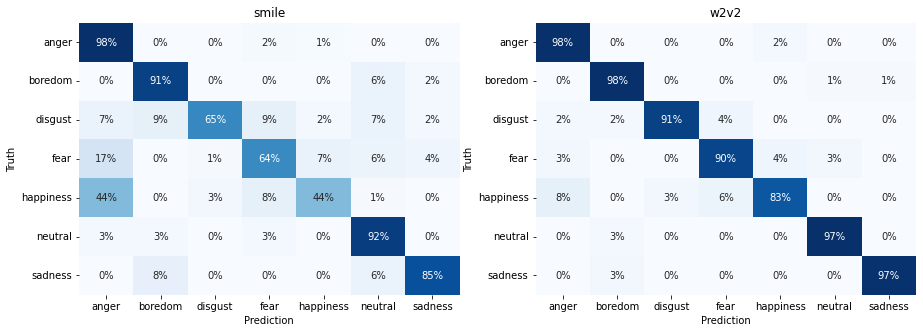

In [15]:
import audplot
import matplotlib.pyplot as plt


_, axs = plt.subplots(1, 2, figsize=[15, 5])

axs[0].set_title('smile')
audplot.confusion_matrix(
    truth_smile, 
    pred_smile,
    percentage=True,    
    ax=axs[0],
)

axs[1].set_title('w2v2')
audplot.confusion_matrix(
    truth_w2v2, 
    pred_w2v2,
    percentage=True,
    ax=axs[1],
)